In [1]:
CONFIG_UNKNOWN = '../logs/sampling_strategy/run_25/config.json'
MODEL_PATH_UNKNOWN = "../logs/sampling_strategy/run_25/best.pth"
CONFIG_KNOWN = '../logs/sampling_strategy/run_29/config.json'
MODEL_PATH_KNOWN = "../logs/sampling_strategy/run_29/best.pth"

In [2]:
import json
import random

from IPython.display import Audio, display
import matplotlib.pyplot as plt
import sys
import os

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(os.path.abspath('../'))

with open(CONFIG_KNOWN) as f:
    cfg = json.load(f)

class Config:
    def __init__(self, dictionary):
        for k, v in dictionary.items():
            if isinstance(v, dict):
                setattr(self, k, Config(v))
            else:
                setattr(self, k, v)

cfg = Config(cfg)
cfg.data.root = os.path.join('..', 'data')
print(cfg.training.sampling_strategy)
cfg.data.unknown_commands_included = True
cfg.data.silence_included = True

None


In [3]:
from dataset.dataset import SpeechCommandsDataset, get_loader

train_dataset = SpeechCommandsDataset(
    root_dir=cfg.data.root,
    cfg=cfg,
    mode='training'
)

test_dataset = SpeechCommandsDataset(
    root_dir=cfg.data.root,
    cfg=cfg,
    mode='testing'
)

Class balance in training data:
  no: 1853
  go: 1861
  _silence_: 320
  on: 1864
  right: 1852
  stop: 1885
  off: 1839
  up: 1843
  yes: 1860
  down: 1842
  left: 1839
  _unknown_: 32550
  unknown percentage: 63.32%
Class balance in testing data:
  down: 253
  go: 251
  left: 267
  no: 252
  off: 262
  on: 246
  right: 259
  stop: 249
  up: 272
  yes: 256
  _silence_: 39
  _unknown_: 4268
  unknown percentage: 62.09%


In [4]:
import torch
from modeling.model import build_model, EnsembleStrategy

model_known = build_model(cfg, 11)

state_dict = torch.load(MODEL_PATH_KNOWN, map_location=torch.device('cpu'))
model_known.load_state_dict(state_dict)

model_unknown = build_model(cfg, 2)

state_dict = torch.load(MODEL_PATH_UNKNOWN, map_location=torch.device('cpu'))
model_unknown.load_state_dict(state_dict)

model = EnsembleStrategy(model_unknown, model_known)
model.eval()

print("Model loaded successfully!")

/home/mytkom/Documents/DeepLearningSpeechRecognition/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded successfully!


<Figure size 1000x1000 with 0 Axes>

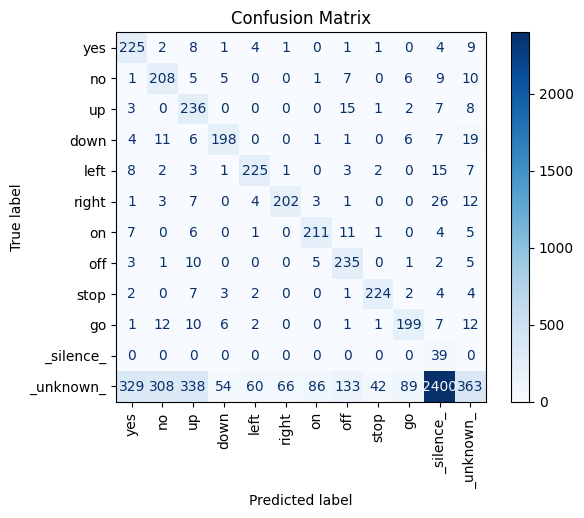

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def evaluate_and_plot_confusion_matrix(model, test_dataset):
    model.eval()
    
    true_labels = []
    predicted_labels = []
    
    for idx in range(len(test_dataset)):
        data, true_label = test_dataset[idx]
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)
        
        with torch.no_grad():
            output = model(data_tensor)
            predicted_label = torch.argmax(output, dim=1).item()
        
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_dataset.label_mapping.keys()))
    
    plt.figure(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

evaluate_and_plot_confusion_matrix(model, test_dataset)